In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.datasets import fashion_mnist
import wandb

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bullseye2608 (bullseye2608-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
def create_validation_set(X, Y, val_ratio=0.2, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
    split_index = int(n_samples * (1 - val_ratio))
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]
    
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_val = X[val_indices]
    Y_val = Y[val_indices]
    
    return X_train, X_val, Y_train, Y_val

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
(X_train, X_val, y_train, y_val) = create_validation_set(X_train, y_train, val_ratio=0.1, seed=42)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create a DataFrame for the training data
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0
train_df = pd.DataFrame(X_train_flat)
train_df['label'] = y_train
train_df['label_name'] = [class_names[label] for label in y_train]

# Create a DataFrame for the validation data
X_val_flat = X_val.reshape(X_val.shape[0], -1) / 255.0
val_df = pd.DataFrame(X_val_flat)
val_df['label'] = y_val
val_df['label_name'] = [class_names[label] for label in y_val]

# Create a DataFrame for the test data
X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255.0
test_df = pd.DataFrame(X_test_flat)
test_df['label'] = y_test
test_df['label_name'] = [class_names[label] for label in y_test]

LOG_EACH = False

In [4]:
class WandbCallback:
    def __init__(self):
        self.epoch = 0
    
    def on_epoch_end(self, loss, val_accuracy):
        wandb.log({
            "epoch": self.epoch,
            "train_loss": loss,
            "val_accuracy": val_accuracy
        })
        self.epoch += 1
    
# Base Optimizer class
class Optimizer:
    def __init__(self, W, B, **kwargs):
        """
        Initialize optimizer with weights and biases shapes.
        
        Parameters:
        W (list): List of weight matrices
        B (list): List of bias vectors
        **kwargs: Optimizer-specific parameters
        """
        self.L = len(W)  # Number of layers
        self.params = kwargs
    
    def update(self, W, B, dW, dB, iteration):
        """
        Update weights and biases based on gradients.
        
        Parameters:
        W (list): Current weights
        B (list): Current biases
        dW (list): Weight gradients
        dB (list): Bias gradients
        iteration (int): Current iteration number
        
        Returns:
        tuple: (new_W, new_B) updated weights and biases
        """
        raise NotImplementedError("Each optimizer must implement this method")


class SGDOptimizer(Optimizer):
    def __init__(self, W, B, learning_rate=0.01, **kwargs):
        super().__init__(W, B, **kwargs)
        self.learning_rate = learning_rate
    
    def update(self, W, B, dW, dB, iteration):
        if LOG_EACH and iteration==0:
            print(f'Running SGDOptimizer {self.learning_rate = }')
        for i in range(self.L):
            W[i] -= self.learning_rate * dW[i]
            B[i] -= self.learning_rate * dB[i]
        return W, B


class MomentumOptimizer(Optimizer):
    def __init__(self, W, B, learning_rate=0.01, momentum=0.9, **kwargs):
        super().__init__(W, B, **kwargs)
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        # Initialize velocity vectors
        self.v_W = [np.zeros_like(W[i]) for i in range(self.L)]
        self.v_B = [np.zeros_like(B[i]) for i in range(self.L)]
    
    def update(self, W, B, dW, dB, iteration):
        if LOG_EACH and iteration==0:
            print(f'Running MomentumOptimizer {self.learning_rate = } {self.momentum = }')
        for i in range(self.L):
            # Update velocity
            self.v_W[i] = self.momentum * self.v_W[i] - self.learning_rate * dW[i]
            self.v_B[i] = self.momentum * self.v_B[i] - self.learning_rate * dB[i]
            
            # Update parameters
            W[i] += self.v_W[i]
            B[i] += self.v_B[i]
        
        return W, B


class NesterovOptimizer(Optimizer):
    def __init__(self, W, B, learning_rate=0.01, momentum=0.9, **kwargs):
        super().__init__(W, B, **kwargs)
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        # Initialize velocity vectors
        self.v_W = [np.zeros_like(W[i]) for i in range(self.L)]
        self.v_B = [np.zeros_like(B[i]) for i in range(self.L)]
    
    def update(self, W, B, dW, dB, iteration):
        if LOG_EACH and iteration==0:
            print(f'Running NesterovOptimizer {self.learning_rate = } {self.momentum = }')
        W_lookahead = [None] * self.L
        B_lookahead = [None] * self.L
        
        # Calculate lookahead position
        for i in range(self.L):
            W_lookahead[i] = W[i] + self.momentum * self.v_W[i]
            B_lookahead[i] = B[i] + self.momentum * self.v_B[i]
        
        # Update velocity
        for i in range(self.L):
            self.v_W[i] = self.momentum * self.v_W[i] - self.learning_rate * dW[i]
            self.v_B[i] = self.momentum * self.v_B[i] - self.learning_rate * dB[i]
            
            # Update parameters
            W[i] += self.v_W[i]
            B[i] += self.v_B[i]
        
        return W, B


class RMSpropOptimizer(Optimizer):
    def __init__(self, W, B, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8, **kwargs):
        super().__init__(W, B, **kwargs)
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        
        # Initialize cache vectors
        self.cache_W = [np.zeros_like(W[i]) for i in range(self.L)]
        self.cache_B = [np.zeros_like(B[i]) for i in range(self.L)]
    
    def update(self, W, B, dW, dB, iteration):
        if LOG_EACH and iteration==0:
            print(f'Running RMSpropOptimizer {self.learning_rate = } {self.decay_rate = } {self.epsilon = }')
        for i in range(self.L):
            # Update cache with squared gradients
            self.cache_W[i] = self.decay_rate * self.cache_W[i] + (1 - self.decay_rate) * np.square(dW[i])
            self.cache_B[i] = self.decay_rate * self.cache_B[i] + (1 - self.decay_rate) * np.square(dB[i])
            
            # Update parameters
            W[i] -= self.learning_rate * dW[i] / (np.sqrt(self.cache_W[i]) + self.epsilon)
            B[i] -= self.learning_rate * dB[i] / (np.sqrt(self.cache_B[i]) + self.epsilon)
        
        return W, B


class AdamOptimizer(Optimizer):
    def __init__(self, W, B, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, **kwargs):
        super().__init__(W, B, **kwargs)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        # Initialize moment vectors
        self.m_W = [np.zeros_like(W[i]) for i in range(self.L)]
        self.m_B = [np.zeros_like(B[i]) for i in range(self.L)]
        
        # Initialize velocity vectors
        self.v_W = [np.zeros_like(W[i]) for i in range(self.L)]
        self.v_B = [np.zeros_like(B[i]) for i in range(self.L)]
    
    def update(self, W, B, dW, dB, iteration):
        if LOG_EACH and iteration==0:
            print(f'Running AdamOptimizer {self.learning_rate = } {self.beta1 = } {self.beta2 = } {self.epsilon = }')
        t = iteration + 1  # Timestep starts at 1
        
        for i in range(self.L):
            # Update biased first and second moment estimates
            self.m_W[i] = self.beta1 * self.m_W[i] + (1 - self.beta1) * dW[i]
            self.m_B[i] = self.beta1 * self.m_B[i] + (1 - self.beta1) * dB[i]
            
            self.v_W[i] = self.beta2 * self.v_W[i] + (1 - self.beta2) * np.square(dW[i])
            self.v_B[i] = self.beta2 * self.v_B[i] + (1 - self.beta2) * np.square(dB[i])
            
            # Compute bias-corrected first and second moment estimates
            m_W_corrected = self.m_W[i] / (1 - self.beta1**t)
            m_B_corrected = self.m_B[i] / (1 - self.beta1**t)
            
            v_W_corrected = self.v_W[i] / (1 - self.beta2**t)
            v_B_corrected = self.v_B[i] / (1 - self.beta2**t)
            
            # Update parameters
            W[i] -= self.learning_rate * m_W_corrected / (np.sqrt(v_W_corrected) + self.epsilon)
            B[i] -= self.learning_rate * m_B_corrected / (np.sqrt(v_B_corrected) + self.epsilon)
        
        return W, B


class NadamOptimizer(Optimizer):
    def __init__(self, W, B, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, **kwargs):
        super().__init__(W, B, **kwargs)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        # Initialize moment vectors
        self.m_W = [np.zeros_like(W[i]) for i in range(self.L)]
        self.m_B = [np.zeros_like(B[i]) for i in range(self.L)]
        
        # Initialize velocity vectors
        self.v_W = [np.zeros_like(W[i]) for i in range(self.L)]
        self.v_B = [np.zeros_like(B[i]) for i in range(self.L)]
    
    def update(self, W, B, dW, dB, iteration):
        if LOG_EACH and iteration==0:
            print(f'Running NadamOptimizer {self.learning_rate = } {self.beta1 = } {self.beta2 = } {self.epsilon = }')
        t = iteration + 1  # Timestep starts at 1
        
        for i in range(self.L):
            # Update biased first and second moment estimates
            self.m_W[i] = self.beta1 * self.m_W[i] + (1 - self.beta1) * dW[i]
            self.m_B[i] = self.beta1 * self.m_B[i] + (1 - self.beta1) * dB[i]
            
            self.v_W[i] = self.beta2 * self.v_W[i] + (1 - self.beta2) * np.square(dW[i])
            self.v_B[i] = self.beta2 * self.v_B[i] + (1 - self.beta2) * np.square(dB[i])
            
            # Compute bias-corrected first and second moment estimates
            m_W_corrected = self.m_W[i] / (1 - self.beta1**t)
            m_B_corrected = self.m_B[i] / (1 - self.beta1**t)
            
            v_W_corrected = self.v_W[i] / (1 - self.beta2**t)
            v_B_corrected = self.v_B[i] / (1 - self.beta2**t)
            
            # Apply Nesterov momentum to first moment estimate
            m_W_nesterov = self.beta1 * m_W_corrected + (1 - self.beta1) * dW[i] / (1 - self.beta1**t)
            m_B_nesterov = self.beta1 * m_B_corrected + (1 - self.beta1) * dB[i] / (1 - self.beta1**t)
            
            # Update parameters
            W[i] -= self.learning_rate * m_W_nesterov / (np.sqrt(v_W_corrected) + self.epsilon)
            B[i] -= self.learning_rate * m_B_nesterov / (np.sqrt(v_B_corrected) + self.epsilon)
        
        return W, B


# Example usage:
def one_hot_encode(labels, num_classes):
    """Convert numeric labels to one-hot encoded vectors"""
    m = labels.shape[0]
    one_hot = np.zeros((num_classes, m))
    for i in range(m):
        one_hot[labels[i], i] = 1
    return one_hot

# Example of how to use the framework
def example_usage():
    # Generate some synthetic data
    np.random.seed(42)
    X = np.random.randn(2, 500)  # 500 examples with 2 features
    y = (X[0, :] > 0).astype(int)  # Binary classification
    y_one_hot = one_hot_encode(y, 2)  # One-hot encode
    
    # Create a neural network with 2-5-2 architecture
    layer_sizes = [2, 5, 2]
    activation_functions = ['relu', 'softmax']
    
    nn = NeuralNetwork(layer_sizes, activation_functions)
    
    # Set optimizer and train
    nn.set_optimizer('adam', learning_rate=0.01, beta1=0.9, beta2=0.999)
    
    # Train the network
    history = nn.train(X, y_one_hot, batch_size=32, num_epochs=10, log_every=50)
    
    # Make predictions
    predictions = nn.predict(X)
    predicted_classes = np.argmax(predictions, axis=0)
    
    # Calculate accuracy
    accuracy = np.mean(predicted_classes == y)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    return nn, history

# To add a new optimizer like Eve, simply create a new class:
class EveOptimizer(Optimizer):
    def __init__(self, W, B, learning_rate=0.001, beta1=0.9, beta2=0.999, beta3=0.999, k=0.1, K=10, **kwargs):
        super().__init__(W, B, **kwargs)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta3 = beta3
        self.k = k
        self.K = K
        self.epsilon = 1e-8
        
        # Initialize Adam moment vectors
        self.m_W = [np.zeros_like(W[i]) for i in range(self.L)]
        self.m_B = [np.zeros_like(B[i]) for i in range(self.L)]
        self.v_W = [np.zeros_like(W[i]) for i in range(self.L)]
        self.v_B = [np.zeros_like(B[i]) for i in range(self.L)]
        
        # Eve-specific variables
        self.d = 1  # Initial value for d
        self.prev_loss = None  # Previous loss
        
    def update(self, W, B, dW, dB, iteration, current_loss=None):
        if current_loss is None:
            # If loss is not provided, use a placeholder (not ideal)
            current_loss = 1.0
            
        t = iteration + 1  # Timestep starts at 1
        
        # Update d based on loss change - Eve's special feature
        if self.prev_loss is not None:
            delta_loss = abs((current_loss / self.prev_loss) - 1)
            c = min(max(delta_loss, 1/self.K), self.k)
            
            if current_loss >= self.prev_loss:
                self.d *= (1 + c)
            else:
                self.d /= (1 + c)
        
        self.prev_loss = current_loss
        
        # Update parameters using Adam with the d factor
        for i in range(self.L):
            # Update biased first and second moment estimates (same as Adam)
            self.m_W[i] = self.beta1 * self.m_W[i] + (1 - self.beta1) * dW[i]
            self.m_B[i] = self.beta1 * self.m_B[i] + (1 - self.beta1) * dB[i]
            
            self.v_W[i] = self.beta2 * self.v_W[i] + (1 - self.beta2) * np.square(dW[i])
            self.v_B[i] = self.beta2 * self.v_B[i] + (1 - self.beta2) * np.square(dB[i])
            
            # Compute bias-corrected first and second moment estimates
            m_W_corrected = self.m_W[i] / (1 - self.beta1**t)
            m_B_corrected = self.m_B[i] / (1 - self.beta1**t)
            
            v_W_corrected = self.v_W[i] / (1 - self.beta2**t)
            v_B_corrected = self.v_B[i] / (1 - self.beta2**t)
            
            # Update parameters with Eve's d factor
            W[i] -= (self.learning_rate / self.d) * m_W_corrected / (np.sqrt(v_W_corrected) + self.epsilon)
            B[i] -= (self.learning_rate / self.d) * m_B_corrected / (np.sqrt(v_B_corrected) + self.epsilon)
        
        return W, B


In [5]:
class NeuralNetwork:
    def __init__(self, layer_sizes=[784, 17, 19, 10], 
                 activation_functions=['sigmoid', 'sigmoid', 'softmax'], 
                 weight_decay=0.0, weight_init='random'):
        assert len(layer_sizes) == len(activation_functions) + 1, "Number of layers (excluding input layer) and activations must match"
        self.layer_sizes = layer_sizes
        self.L = len(layer_sizes) - 1
        self.activation_functions = activation_functions
        
        if weight_init == 'random':
            self.W = [np.random.uniform(-0.5, 0.5, (self.layer_sizes[i], self.layer_sizes[i - 1])) for i in range(1, len(self.layer_sizes))]
            self.B = [np.zeros(self.layer_sizes[i]).reshape(1,-1) for i in range(1, len(self.layer_sizes))]
        elif weight_init == 'xavier':
            # Xavier/Glorot initialization for weights
            self.W = [np.random.randn(self.layer_sizes[i], self.layer_sizes[i - 1]) * 
                    np.sqrt(2.0 / (self.layer_sizes[i] + self.layer_sizes[i - 1])) 
                    for i in range(1, len(self.layer_sizes))]
            self.B = [np.zeros(self.layer_sizes[i]).reshape(1,-1) for i in range(1, len(self.layer_sizes))]
        else:
            raise ValueError(f"Unsupported weight initialization: {weight_init}")
        
        self.weight_decay = weight_decay
        
        self.optimizer = None
    
    def set_optimizer(self, optimizer_dict):
        optimizer_map = {
            'sgd': SGDOptimizer,
            'momentum': MomentumOptimizer,
            'nesterov': NesterovOptimizer,
            'rmsprop': RMSpropOptimizer,
            'adam': AdamOptimizer,
            'nadam': NadamOptimizer
        }

        if optimizer_dict['name'] not in optimizer_map:
            raise ValueError(f"Unsupported optimizer: {optimizer_dict['name']}")
        
        self.optimizer = optimizer_map[optimizer_dict['name']](self.W, self.B, **optimizer_dict)
    
    def activate(self, A, activation):
        if activation == 'sigmoid':
            return 1 / (1 + np.exp(-A))
        elif activation == 'relu':
            return np.maximum(0, A)
        elif activation == 'tanh':
            return np.tanh(A)
        elif activation == 'softmax':
            # For numerical stability, subtract max value
            exps = np.exp(A - np.max(A, axis=-1, keepdims=True))
            return exps / np.sum(exps, axis=-1, keepdims=True)
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def _activate_derivative(self, Z, A, activation):
        """Calculate derivative of activation function"""
        if activation == 'sigmoid':
            return A * (1 - A)
        elif activation == 'relu':
            return (Z > 0).astype(float)
        elif activation == 'tanh':
            return 1 - A**2
        elif activation == 'softmax':
            # This is already handled in backpropagation for softmax+cross entropy
            return 1
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward_propagation(self, X):
        H = [X]
        A = []
        
        for i in range(self.L):
            A.append(np.dot(H[i], self.W[i].T) + self.B[i])
            H.append(self.activate(A[i], self.activation_functions[i]))
        
        return H, A
    
    def compute_loss(self, H_final, y, loss_type='cross_entropy'):
        if y.ndim == 1:
            y = self.one_hot(y)
        m = y.shape[0]  # Number of examples
        
        if loss_type == 'cross_entropy':
            # Add small epsilon to avoid log(0)
            epsilon = 1e-15
            loss = -np.sum(y * np.log(H_final + epsilon)) / m
        elif loss_type == 'mse':
            loss = np.sum((H_final - y)**2) / (2 * m)
        else:
            raise ValueError(f"Unsupported loss function: {loss_type}")
            
        return loss
    
    def _loss_derivative(self, A_final, y, loss_type):
        if loss_type == 'cross_entropy':
            epsilon = 1e-15
            return -y / (A_final + epsilon)
        elif loss_type == 'mse':
            return A_final - y
        else:
            raise ValueError(f"Unsupported loss function: {loss_type}")
    
    def one_hot(self, y):
        one_hot_y = np.zeros((y.size, self.layer_sizes[-1]))
        one_hot_y[np.arange(y.size), y] = 1
        return one_hot_y
    
    def back_propagation(self, X, y, H, A, loss_type='cross_entropy'):
        assert len(H) == self.L + 1 and len(A) == self.L
        N = X.shape[0]
        assert N==y.size and self.L==len(A) and self.L + 1==len(H)
        
        dW, dB = [None] * self.L, [None] * self.L
        
        if loss_type == 'cross_entropy' and self.activation_functions[-1] == 'softmax':
            # Gradient simplifies when using softmax + cross entropy
            dA = H[-1] - self.one_hot(y)
        else:
            dH = self._loss_derivative(H[-1], y, loss_type)
            dA = dH * self._activate_derivative(A[-1], H[-1], self.activation_functions[-1])
            
        dW[-1] = np.dot(dA.T, H[-2]) / N
        dB[-1] = np.sum(dA, axis=0, keepdims=True) / N
        
        for k in range(self.L-2, -1, -1):
            
            dA = np.dot(dA, self.W[k+1]) * self._activate_derivative(A[k], H[k+1], self.activation_functions[k])
            
            dWk = (np.dot(dA.T, H[k])) / N
            dBk = np.sum(dA, axis=0, keepdims=True) / N
            dW[k] = dWk
            dB[k] = dBk
        
        if self.weight_decay > 0:
            for i in range(len(self.W)):
                dW[i] += self.weight_decay * self.W[i]
               
        return dW, dB
    
    def plot_history(self, history):
        plt.figure(figsize=(12, 6))
        plt.plot(history['train_loss'], label='Training Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    def predict(self, X):
        H, _ = self.forward_propagation(X)
        return H[-1]
    
    def compute_accuracy(self, X, y):
        y_pred = np.argmax(self.predict(X), axis=1)
        return np.mean(y_pred == y)
    
    def train(self, X_train, y_train, X_val=None, y_val=None, 
              batch_size=32, num_epochs=100, loss_type='cross_entropy', 
              log_every=100, callback=None):
        
        if self.optimizer is None:
            self.set_optimizer({'name':'sgd', 'learning_rate':0.01})
        
        num_datapoints = X_train.shape[0]
        num_batches = int(np.ceil(num_datapoints / batch_size))
        
        spacer_1 = int(np.log10(num_epochs)+1)
        spacer_2 = int(np.log10(num_batches)+1)
        
        history = {
            'train_loss' : [],
            'val_loss' : [] if X_val is not None else None
        }
        
        iteration = 0
        
        for epoch in range(num_epochs):
            
            permutation = np.random.permutation(num_datapoints)
            X_train = X_train[permutation]
            y_train = y_train[permutation]
            
            for batch in range(num_batches):
                start_idx = batch * batch_size
                end_idx = min((batch + 1) * batch_size, num_datapoints)
                X_batch = X_train[start_idx:end_idx]
                y_batch = y_train[start_idx:end_idx]
                
                H, A = self.forward_propagation(X_batch)
                dW, dB = self.back_propagation(X_batch, y_batch, H, A, loss_type)
                
                self.W, self.B = self.optimizer.update(self.W, self.B, dW, dB, iteration)
                
                if iteration % log_every == 0:
                    train_loss = self.compute_loss(H[-1], y_batch, loss_type)
                    history['train_loss'].append(train_loss)
                    
                    if X_val is not None and y_val is not None:
                        val_loss = self.compute_loss(self.predict(X_val), y_val, loss_type)
                        history['val_loss'].append(val_loss)
                        if LOG_EACH:    print(f"Epoch {epoch+1 :>{spacer_1}}/{num_epochs}, Iteration {iteration%num_batches :>{spacer_2}}/{num_batches} --> Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")
                    else:
                        if LOG_EACH:    print(f"Epoch {epoch+1 :>{spacer_1}}/{num_epochs}, Iteration {iteration%num_batches :>{spacer_2}}/{num_batches} --> Train Loss: {train_loss:.5f}")
                
                iteration += 1
            
            if callback is not None:
                callback.on_epoch_end(train_loss, self.compute_accuracy(X_val, y_val))
                
        return history
    

### Trials

In [17]:
nn = NeuralNetwork(layer_sizes=[784, 16, 16, 10], 
                   activation_functions=['sigmoid', 'sigmoid', 'softmax'], 
                   weight_init='xavier',
                   weight_decay=0.0)

# H, A = nn.forward_propagation(X_train_flat)
# loss = nn.compute_loss(H[-1], y_train)
# nn.compute_accuracy(X_val_flat, y_val)

nn.set_optimizer({'name':'rmsprop', 'learning_rate':0.01, 'beta':0.69, 'epsilon':1e-5})

num_trial_datapoints = 10000

hist = nn.train(X_train_flat[:num_trial_datapoints], 
         y_train[:num_trial_datapoints], 
         X_val_flat, y_val, 
         batch_size=128, 
         num_epochs=100, 
         loss_type='cross_entropy', 
         log_every=5000)

print('DONE')

DONE


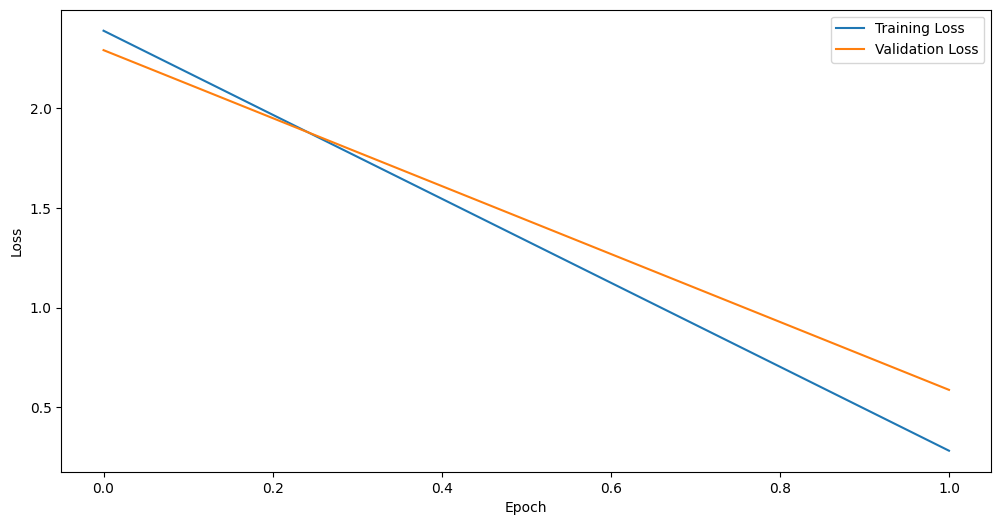

In [18]:
nn.plot_history(hist)

In [19]:
num_trial_datapoints = 10000

nn.train(X_train_flat[:num_trial_datapoints], 
         y_train[:num_trial_datapoints], 
         X_val_flat, y_val, 
         batch_size=64, 
         num_epochs=10, 
         loss_type='cross_entropy', 
         log_every=5000)

print('--'*20,'DONE','--'*20)
print(nn.compute_accuracy(X_test_flat, y_test))

---------------------------------------- DONE ----------------------------------------
0.8256


In [20]:
nn.compute_accuracy(X_test_flat, y_test)

0.8256

### WANDB SWEEP

In [8]:
def get_optimizer(name, learning_rate):
    # This should match how your NeuralNetwork class handles optimizers
    if name == 'sgd':
        return {'name': 'sgd','learning_rate': learning_rate}
    elif name == 'momentum':
        return {'name': 'momentum','learning_rate': learning_rate, 'momentum': 0.9}
    elif name == 'nesterov':
        return {'name': 'nesterov','learning_rate': learning_rate, 'momentum': 0.9}
    elif name == 'rmsprop':
        return {'name': 'rmsprop','learning_rate': learning_rate, 'beta': 0.9, 'epsilon': 1e-8}
    elif name == 'adam':
        return {'name': 'adam','learning_rate': learning_rate, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
    elif name == 'nadam':
        return {'name': 'nadam','learning_rate': learning_rate, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
    else:
        raise ValueError(f"Optimizer {name} not recognized")
    
def wandb_sweep_helper_function(config=None):
    with wandb.init(
        entity="bullseye2608-indian-institute-of-technology-madras",
        project="fashion_mnist_hp_search",
        config=config):
        
        config = wandb.config
        
        
        layer_sizes = [784] + [config.hidden_size]*config.hidden_layers + [10]
        activation_functions = [config.activation]*config.hidden_layers + ['softmax']
        
        nn = NeuralNetwork(layer_sizes=layer_sizes, 
                           activation_functions=activation_functions,
                           weight_init=config.weight_init, 
                           weight_decay=config.weight_decay)
        
        wandb_callback = WandbCallback()
        
        optimizer = get_optimizer(config.optimizer, config.learning_rate)
        nn.set_optimizer(optimizer)
        
        history = nn.train(
            X_train_flat, 
            y_train, 
            X_val_flat, 
            y_val, 
            batch_size=config.batch_size, 
            num_epochs=config.epochs, 
            loss_type='cross_entropy', 
            log_every=1000,
            callback=wandb_callback  # Assuming your NeuralNetwork class supports callbacks
        )
        
        test_accuracy = nn.compute_accuracy(X_test_flat, y_test)
        wandb.log({"test_accuracy": test_accuracy})
        print(f"Test Accuracy: {test_accuracy:.4f}")
        
        return history
        
sweep_config = {
    'method': 'bayes',  # Bayesian optimization strategy
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5, 10]
        },
        'hidden_layers': {
            'values': [3, 4, 5]
        },
        'hidden_size': {
            'values': [32, 64, 128]
        },
        'weight_decay': {
            'values': [0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'weight_init': {
            'values': ['random', 'xavier']
        },
        'activation': {
            'values': ['sigmoid', 'tanh', 'relu']
        }
    }
}   
        

In [7]:
# Create sweep
sweep_name = "fashion_mnist_nn_sweep"
sweep_id = wandb.sweep(sweep_config, 
                       entity="bullseye2608-indian-institute-of-technology-madras",
                       project="fashion_mnist_hp_search")

# Run the sweep
wandb.agent(sweep_id, wandb_sweep_helper_function, count=60)

Create sweep with ID: phko9oz2
Sweep URL: https://wandb.ai/bullseye2608-indian-institute-of-technology-madras/fashion_mnist_hp_search/sweeps/phko9oz2


wandb: Agent Starting Run: 3ahamd5g with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8032


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▃▃▂▂▁▂▃▁
val_accuracy,▁▄▅▆▆▇▇███
epoch,9
test_accuracy,0.8032
train_loss,0.32728
val_accuracy,0.81133


wandb: Agent Starting Run: p4j5lbjy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8661


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▃▂▄
val_accuracy,▄▁███
epoch,4
test_accuracy,0.8661
train_loss,0.3892
val_accuracy,0.87


wandb: Agent Starting Run: v5ki60h2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8576


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▂▁▂▂▁▁▁
val_accuracy,▁▄▅▆▆▆▇███
epoch,9
test_accuracy,0.8576
train_loss,0.21378
val_accuracy,0.86717


wandb: Agent Starting Run: 9oi3p0sp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8534


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▇▅▆▁
val_accuracy,▁▄▇▇█
epoch,4
test_accuracy,0.8534
train_loss,0.13291
val_accuracy,0.85917


wandb: Agent Starting Run: 65fdhv13 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.2925


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,██████▇▅▃▁
val_accuracy,▁▁▁▁▂▃▄█▆▇
epoch,9
test_accuracy,0.2925
train_loss,1.6741
val_accuracy,0.28833


wandb: Agent Starting Run: vbqqq2u5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.7319


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▂▂▁▃▂▁▄
val_accuracy,▁▄▅▆▇▇▇███
epoch,9
test_accuracy,0.7319
train_loss,1.25797
val_accuracy,0.7355


wandb: Agent Starting Run: uiaupkhf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8589


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▂
val_accuracy,▁▄▆▆█
epoch,4
test_accuracy,0.8589
train_loss,0.55953
val_accuracy,0.866


wandb: Agent Starting Run: t9umm0ps with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8621


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▄▃▄▃▄▄▆▁
val_accuracy,▁▄▄▆▆▆▆▇██
epoch,9
test_accuracy,0.8621
train_loss,0.1417
val_accuracy,0.869


wandb: Agent Starting Run: eo4ev5on with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.7058


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▁▅▆██
epoch,4
test_accuracy,0.7058
train_loss,0.9604
val_accuracy,0.70517


wandb: Agent Starting Run: 98gb1cin with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▁▄▇▇██████
val_accuracy,██▆▃▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30509
val_accuracy,0.10117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xv38th6m with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.6451


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▇▆▄▁
val_accuracy,▁▃▄▇█
epoch,4
test_accuracy,0.6451
train_loss,1.07838
val_accuracy,0.6515


wandb: Agent Starting Run: 92wzkdla with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▄█▅▇▁▁▁▁▁▆
epoch,9
test_accuracy,0.1
train_loss,2.30055
val_accuracy,0.10117


wandb: Agent Starting Run: tbgvczqd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.2355


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▃▆▁
val_accuracy,▁▄▆█▇
epoch,4
test_accuracy,0.2355
train_loss,2.28669
val_accuracy,0.23083


wandb: Agent Starting Run: g2k7e4g3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▃▂▄▁▄▆▇█▂▇
val_accuracy,▆▅█▇▂▅▁▅▇▅
epoch,9
test_accuracy,0.1
train_loss,2.30949
val_accuracy,0.1


wandb: Agent Starting Run: 56b4aj19 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8456


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▂▂▁▁▁▁▁▂
val_accuracy,▁▄▅▆▆▇▇▇██
epoch,9
test_accuracy,0.8456
train_loss,0.58425
val_accuracy,0.8515


wandb: Agent Starting Run: r8klbtht with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8724


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▄▃█▅▁▂▄▂▂▂
val_accuracy,▁▄▅▆▇▅████
epoch,9
test_accuracy,0.8724
train_loss,0.29707
val_accuracy,0.87983


wandb: Agent Starting Run: 9nbxgsx0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8474


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▁▁▁
val_accuracy,▁▄▆▇█
epoch,4
test_accuracy,0.8474
train_loss,0.51851
val_accuracy,0.857


wandb: Agent Starting Run: gxjo6gjj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8177


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
epoch,9
test_accuracy,0.8177
train_loss,0.4523
val_accuracy,0.82417


wandb: Agent Starting Run: zxji6ez6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8173


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
epoch,9
test_accuracy,0.8173
train_loss,0.5749
val_accuracy,0.8235


wandb: Agent Starting Run: finu1vp6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8546


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▂▁▂▁▁▁▂▂
val_accuracy,▁▄▅▆▇▆▇▇██
epoch,9
test_accuracy,0.8546
train_loss,0.48056
val_accuracy,0.85783


wandb: Agent Starting Run: wyj6niao with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8662


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇▇▇▇▇█
epoch,9
test_accuracy,0.8662
train_loss,0.43417
val_accuracy,0.87033


wandb: Agent Starting Run: cb5s7j5i with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8642


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇█▇██
epoch,9
test_accuracy,0.8642
train_loss,0.34883
val_accuracy,0.86633


wandb: Agent Starting Run: dxi524vu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8141


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇███
epoch,9
test_accuracy,0.8141
train_loss,0.65341
val_accuracy,0.8195


wandb: Agent Starting Run: 0gm0o300 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8647


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇▆███
epoch,9
test_accuracy,0.8647
train_loss,0.40829
val_accuracy,0.86967


wandb: Agent Starting Run: 1k9prwco with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8712


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▁▁▁▁▂▁
val_accuracy,▁▄▅▅▇▇▇▇▇█
epoch,9
test_accuracy,0.8712
train_loss,0.28439
val_accuracy,0.88183


wandb: Agent Starting Run: csvjwm9s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8682


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▂▁
val_accuracy,▁▃▁▆▅▄▇█▆▆
epoch,9
test_accuracy,0.8682
train_loss,0.2665
val_accuracy,0.86633


wandb: Agent Starting Run: x10e3w0m with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8705


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▂▁▂▂▁▁▁
val_accuracy,▁▃▅▁▇▆▆▇▆█
epoch,9
test_accuracy,0.8705
train_loss,0.21302
val_accuracy,0.88067


wandb: Agent Starting Run: 8ujkslmr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8575


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▆▇▇▇██
epoch,9
test_accuracy,0.8575
train_loss,0.1729
val_accuracy,0.87


wandb: Agent Starting Run: r2oaq7ed with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8200


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▇▆▃▃█▁▂▁▃▆
val_accuracy,▁▄▆▅▇▆▇█▇█
epoch,9
test_accuracy,0.82
train_loss,0.75095
val_accuracy,0.83017


wandb: Agent Starting Run: vj5lmxpu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8491


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▄▄▇▁▃▄▃▂
val_accuracy,▁▃▅▆▆▇▇█▇█
epoch,9
test_accuracy,0.8491
train_loss,0.42361
val_accuracy,0.86167


wandb: Agent Starting Run: 4pyfgq5i with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8762


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▃▆▇▇▇██
epoch,9
test_accuracy,0.8762
train_loss,0.32602
val_accuracy,0.88567


wandb: Agent Starting Run: r6hodcbk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8460


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▂▃▁▃▄▃▁█▂▄
val_accuracy,▂▇▅▃█▄▆▁▁▄
epoch,9
test_accuracy,0.846
train_loss,0.85896
val_accuracy,0.84733


wandb: Agent Starting Run: ffd6kda7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8636


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▆▆▆▇█▇█
epoch,9
test_accuracy,0.8636
train_loss,0.48835
val_accuracy,0.86633


wandb: Agent Starting Run: eks5y3g0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8590


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▇▆▇██▇█
epoch,9
test_accuracy,0.859
train_loss,0.24573
val_accuracy,0.8645


wandb: Agent Starting Run: 4gadnzpa with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8597


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▃▄▂▄▁▃▁▁
val_accuracy,▁▃▆▅▇▇█▅▅█
epoch,9
test_accuracy,0.8597
train_loss,0.28192
val_accuracy,0.86467


wandb: Agent Starting Run: lg5sxjuy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8586


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▆█▃▆▃▃▄▃▁▂
val_accuracy,▁▄▅▇▇▆▇███
epoch,9
test_accuracy,0.8586
train_loss,0.29476
val_accuracy,0.8675


wandb: Agent Starting Run: 579hs4ps with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8683


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▇▇▆██
epoch,9
test_accuracy,0.8683
train_loss,0.24241
val_accuracy,0.87383


wandb: Agent Starting Run: w9ax2aws with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.6663


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▃▁▂
val_accuracy,▁▄▇██
epoch,4
test_accuracy,0.6663
train_loss,1.07908
val_accuracy,0.66967


wandb: Agent Starting Run: kyxzju0y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8603


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▂▁▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇█▇█
epoch,9
test_accuracy,0.8603
train_loss,0.21891
val_accuracy,0.87333


wandb: Agent Starting Run: hfsajhvv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8785


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▂▁▂▁▁▂▁▁
val_accuracy,▁▄▄▆▇▇▇███
epoch,9
test_accuracy,0.8785
train_loss,0.20686
val_accuracy,0.88567


wandb: Agent Starting Run: m0cxaih4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8734


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▅█▂▂▄▄▁▄▁▆
val_accuracy,▁▂▅▅▆▆▇▅▇█
epoch,9
test_accuracy,0.8734
train_loss,0.47933
val_accuracy,0.88117


wandb: Agent Starting Run: 4u7gr500 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8465


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▁▁
val_accuracy,▁▅▅█▇
epoch,4
test_accuracy,0.8465
train_loss,0.13668
val_accuracy,0.8525


wandb: Agent Starting Run: xdiy86n7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8665


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▇▂▁▁▃▅▄▃
val_accuracy,▁▃▅▅▆▇▇▇█▇
epoch,9
test_accuracy,0.8665
train_loss,0.23547
val_accuracy,0.86867


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7bgo73xs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8653


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▂▁▁▁▁▁▁▁
val_accuracy,▁▃▆▆▇█▇▆█▆
epoch,9
test_accuracy,0.8653
train_loss,0.19943
val_accuracy,0.86933


wandb: Agent Starting Run: yr7886o7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8607


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▅█▆█▆▁▅▁
val_accuracy,▁▃▅▆▆▇████
epoch,9
test_accuracy,0.8607
train_loss,0.16949
val_accuracy,0.86833


wandb: Agent Starting Run: slytyyia with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8188


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▁▁▂▂▁▂▁
val_accuracy,▁▄▅▆▇▇▇███
epoch,9
test_accuracy,0.8188
train_loss,0.41087
val_accuracy,0.8255


wandb: Agent Starting Run: ls81lm7u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8088


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▆▆▇████
epoch,9
test_accuracy,0.8088
train_loss,0.52034
val_accuracy,0.81267


wandb: Agent Starting Run: k3eyu3gu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8483


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▂▁▁▂▂▂▂▂
val_accuracy,▁▄▅▅▆▇▇▇██
epoch,9
test_accuracy,0.8483
train_loss,0.44215
val_accuracy,0.85233


wandb: Agent Starting Run: fgilojox with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8527


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▄▄▆▆▅▆▁▆
val_accuracy,▁▆▆█▇▅▇█▇▇
epoch,9
test_accuracy,0.8527
train_loss,0.41047
val_accuracy,0.8615


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 33ioq2j9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8197


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
epoch,9
test_accuracy,0.8197
train_loss,0.41311
val_accuracy,0.828


wandb: Agent Starting Run: 0yk78bli with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8488


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▆▆▇▇▆█
epoch,9
test_accuracy,0.8488
train_loss,0.43389
val_accuracy,0.858


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nw4vr77d with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8606


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▁▂▂▄▁
val_accuracy,▁▃███▆▅███
epoch,9
test_accuracy,0.8606
train_loss,0.16937
val_accuracy,0.867


wandb: Agent Starting Run: 8edwnseh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8780


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▄▅▄▃▁▃█▃▁▂
val_accuracy,▁▃▅▆▅▆█▇▇█
epoch,9
test_accuracy,0.878
train_loss,0.18069
val_accuracy,0.89017


wandb: Agent Starting Run: bb05dxkd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8716


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▂▂▂▂▁▁
val_accuracy,▁▄▅▅▇▇████
epoch,9
test_accuracy,0.8716
train_loss,0.16269
val_accuracy,0.88


wandb: Agent Starting Run: cjl3jhxa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8607


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▆▇▇█
epoch,9
test_accuracy,0.8607
train_loss,0.22988
val_accuracy,0.86967


wandb: Agent Starting Run: p7s29qw6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8696


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▁▁▁▂▁▁
val_accuracy,▁▄▅▆▇▇▆▇██
epoch,9
test_accuracy,0.8696
train_loss,0.32876
val_accuracy,0.87867


wandb: Agent Starting Run: 0vufo4du with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8576


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▆▄▄█▅▅▂▇▃▁
val_accuracy,▁▃▃▄▇▇▇██▇
epoch,9
test_accuracy,0.8576
train_loss,0.07822
val_accuracy,0.86433


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1ju1qg04 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8443


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▁▄▅▇█
epoch,4
test_accuracy,0.8443
train_loss,0.43316
val_accuracy,0.8535


wandb: Agent Starting Run: 455sa42o with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8192


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
epoch,9
test_accuracy,0.8192
train_loss,0.46294
val_accuracy,0.82217


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pq1ogbml with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


_wandb
activation
batch_size
epochs
hidden_layers
hidden_size
learning_rate
optimizer
weight_decay
weight_init
Test Accuracy: 0.8468


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▆▇██▇
epoch,9
test_accuracy,0.8468
train_loss,0.3515
val_accuracy,0.851


In [ ]:
sweep_id_cont = 'phko9oz2'

wandb.agent(sweep_id, wandb_sweep_helper_function, count=60)

wandb: Agent Starting Run: 16jzgrl7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Test Accuracy: 0.8692


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▂▂▁▁▁▂▂▁
val_accuracy,▁▄▆▅▇▇▇▇██
epoch,9
test_accuracy,0.8692
train_loss,0.1663
val_accuracy,0.87617


wandb: Agent Starting Run: e4wyzs02 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Test Accuracy: 0.7978


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇██
epoch,9
test_accuracy,0.7978
train_loss,0.70069
val_accuracy,0.80017


wandb: Agent Starting Run: pp8lvsd4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
